# Running the NUMAR model



Original paper: Chen, Ronghua & Twilley, Robert. (1999). A Simulation Model of Organic Matter and Nutrient Accumulation in Mangrove Wetland Soils. Biogeochemistry. 44. 93-118. 10.1007/BF00993000. https://www.researchgate.net/publication/226714484_A_Simulation_Model_of_Organic_Matter_and_Nutrient_Accumulation_in_Mangrove_Wetland_Soils
- Python Conversion: Tom Kaiser
- Python Wrapper and Notebook: Alex Christensen
- Model Updates For Marsh: Andy Cassaway and Pradipta Biswas




# 1a. Import Python Packages

In [1]:
## if running in Google Colab, uncomment the lines below

# !pip install rasterio
# !pip install earthaccess

# !apt install gdal-bin
# !gdalinfo --version

In [2]:
import sys
import os
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
from  matplotlib.colors import ListedColormap, BoundaryNorm
from  matplotlib.cm import ScalarMappable
import math
import pandas as pd
import earthaccess
import cartopy.crs as ccrs
import imageio
from osgeo import gdal, ogr

earthaccess.login()



Enter your Earthdata Login username:  achri
Enter your Earthdata password:  ········


Authentication with Earthdata Login failed with:
{"error":"invalid_credentials","error_description":"Invalid user credentials"}


# 1b. Set working directories

In [3]:
# if os.path.isdir('/content/deltax_workshop_2024'):
#   !rm -r /content/deltax_workshop_2024
# ! git clone https://github.com/achri19/deltax_workshop_2024.git

# %cd /content/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example

# sys.path.append('/content/deltax_workshop_2024/tutorials/6_NUMARModel/src')


In [4]:
example_dir = Path(os.getcwd())
repo_dir = example_dir.parent.absolute()
script_dir = repo_dir / 'src'
working_dir = repo_dir / 'data'
tmp_dir = example_dir / 'TMP'
Path(tmp_dir).mkdir(parents=True, exist_ok=True)
sys.path.insert(1,str(script_dir))


# 1c. Import NUMAR model

In [6]:
from landscape import run_numar
from input_files import *

In [7]:
Path(tmp_dir).mkdir(parents=True, exist_ok=True)
ref_file = example_dir / 'aoi_4326.shp'
res = 30
AOI = gpd.read_file(ref_file)
bounds_4326 =  AOI.total_bounds

x1,y1,x2,y2 = math.floor(bounds_4326[0]),math.floor(bounds_4326[3]),math.floor(bounds_4326[2]),math.floor(bounds_4326[1])

zone = int(np.ceil((bounds_4326[0] + 180)/6))

if y1>=0 and y2>=0:
    NS = 'n'
    EPSG = 32200+zone
elif y1>=0 and y2<0:
    NS = 'n'
    NS2 = 's'
    EPSG = 32200+zone
else:
    NS = 's'
    y = abs(y1)
    EPSG = 32700+zone
if x1>=0:
    EW = 'e'
elif x1<0 and x2>=0:
    EW = 'e'
    EW2 = 'w'
else:
    EW = 'w'
    x = abs(x1)
print('UTM Zone: %s%s EPSG: %s' %(zone,NS,EPSG))

AOI_utm = AOI.to_crs(EPSG)
AOI_utm.to_file(tmp_dir / ('aoi_%s.shp' %(EPSG)))
os.system("gdal_rasterize -burn 0 -tr %s %s %s %s" %(res,res,tmp_dir/('aoi_%s.shp'%(EPSG)),example_dir / ('aoi_%s.tif'%(EPSG))))
# command = "gdal_rasterize -burn 0 -tr %s %s %s %s" %(res,res,example_dir/('aoi_%s.shp'%(EPSG)),example_dir / ('aoi_%s.tif'%(EPSG)))
# !{command}


UTM Zone: 15n EPSG: 32215
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [8]:
ref_file = example_dir / ('aoi_%s.tif' %(EPSG))
AOI = rasterio.open(ref_file)

profile = AOI.profile


## Get Input Rasters

### You need to download the following files:
- ### Delta-X AVIRIS-NG Aboveground Biomass (spring and Fall)
    - ### https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2138
- ### ESA WorldCover 2021 Landcover Maps
    - ### https://worldcover2021.esa.int/downloader
- ### CPRA Vegetation
    - ### https://cims.coastal.la.gov/Viewer/GISDownload.aspx
    - ### direct download = https://cims.coastal.louisiana.gov/Viewer/metadata/zips/vegtype2021.zip
- ### Delta-X Delft3D Annual inorganic mass accumulation rate (IMAR): annual rates of mineral mass deposited on wetlands, estimated from analysis of storm frequency and deposition.:
    - ### https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2302

In [9]:
AGB, SALINITY, LANDCOVER, MORPHO, BASINS, CLASSES, mask, lats,lons = get_input_files(AOI,example_dir,working_dir,tmp_dir,EPSG,bounds_4326)



##### ABOVEGROUND BIOMASS



##### ESA WorldCover landcover type



##### CPRA Vegetation Type (with Salinity Zones)


##### Modified Hydrologic Basins


##### Delft3D Inorganice Mass Accumulation Rate (IMAR)


# Search EarthData for Delft3D Atchafalaya Sediment Model Data over the AOI

Granules found: 1
# Download IMAR Delft3D data products: 

'NoneType' object has no attribute 'get'
You must call earthaccess.login() before you can download data
# Convert the Delft3D IMAR netCDF4 file to Geotiff

# Search EarthData for Delft3D Terrebonne Sediment Model Data over the AOI

Granules found: 1
# Download IMAR Delft3D data products: 

'NoneType' object has no attribute 'get'
You must call earthaccess.login() before you can download data
# Convert the Delft3D IMAR netCDF4 file to Geotiff

# Merging IMAR tiles

# Crop the Delft3D IMAR file to AOI and resample to 30.0m 

--> Saved as /Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example/Delft3D_IMAR.ti

## Get Input Parameters

### From Delft3D Model IMAR output:
- si = inorganic matter deposition rate on the soil surface (g/cm2/yr)
- oms = organic matter deposition rate on the soil surfcae (g/cm2/yr)

### From AVIRIS-NG Biomass data products:
- r0 = root biomass at the surface (g/cm2)

### Based on landcover type:
- b0 = self-packing density of organic matter (g/cm3)
- bi = self-packing density of inorganic matter (g/cm3)
- c0 = lignin content in the surface deposit (g/g)
- c1 = ash content in the root biomass (g/g)
- c2 = cellulose content in the surface deposit (g/g)
- c4 = cellulose content in the root biomass(g/g)
- fc1 = lignin content in the root biomass
- kb = belowground decomposition rate of labile organic matter (1/yr)
- kc = cellulos decomposition rate (1/yr)
- kl = lignin decomposition rate (1/yr)
- kr = root turnover rate (1/yr)
- e = root attenuation rate

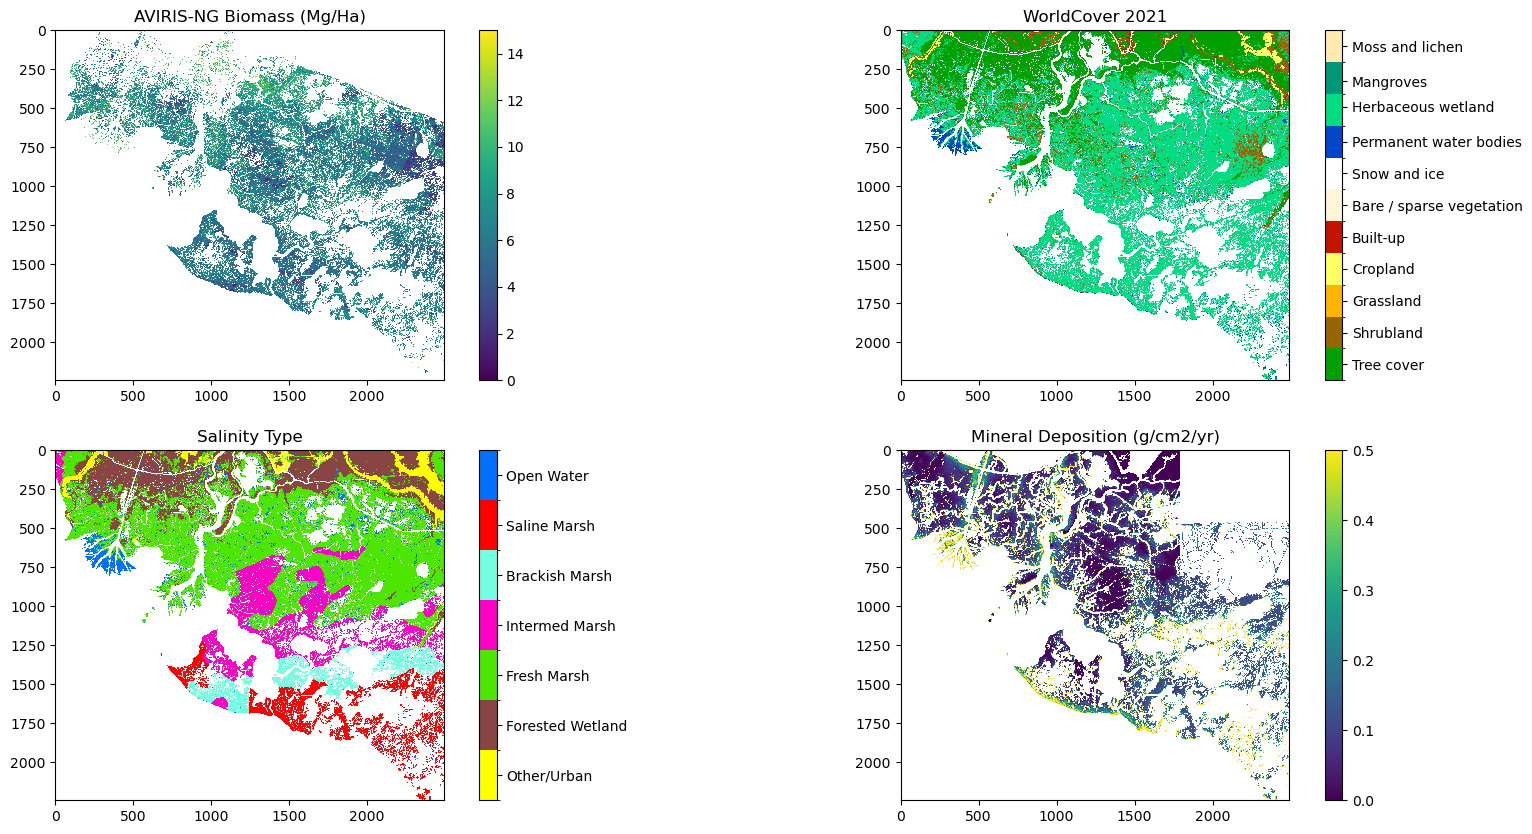

In [10]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize = (20,10))

im1 = ax1.imshow(AGB*mask,vmin=0,vmax=15,interpolation='nearest')
ax1.set_title('AVIRIS-NG Biomass (Mg/Ha)')
fig.colorbar(im1,ax = ax1)


colors = ['#00a000','#966400','#ffb400','#ffff64','#c31400','#fff5d7','#ffffff','#0046c8','#00dc82','#009678','#ffebaf']
values = [10,20,30,40,50,60,70,80,90,95,100]
labels = ["Tree cover","Shrubland","Grassland","Cropland","Built-up","Bare / sparse vegetation","Snow and ice","Permanent water bodies","Herbaceous wetland","Mangroves","Moss and lichen"]
bounds = np.append(values, values[-1] + 2)
ticks = [15,25,35,45,55,65,75,85,93,97,101]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))
im2 = ax2.imshow(LANDCOVER*mask,cmap=cmap,norm=norm,interpolation='nearest')
ax2.set_title('WorldCover 2021')
cbar = fig.colorbar(im2,ax=ax2,ticks = ticks)
cbar.ax.set_yticklabels(labels)  # horizontal colorbar


colors = ['#ffff00','#894444','#4ce600','#ff00c5','#73ffdf','#ff0000','#0070ff']
values =[1,2,3,4,5,6,7]
labels = ['Other/Urban','Forested Wetland','Fresh Marsh','Intermed Marsh','Brackish Marsh','Saline Marsh','Open Water']
bounds = np.append(values, values[-1] + 1)
ticks = [1.5,2.5,3.5,4.5,5.5,6.5,7.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))
im3 = ax3.imshow(SALINITY*mask,cmap=cmap,norm=norm,interpolation='nearest')
cbar = fig.colorbar(im3,ax=ax3,ticks = ticks)
cbar.ax.set_yticklabels(labels)  # horizontal colorbar
ax3.set_title('Salinity Type')


im4 = ax4.imshow(MORPHO*mask,vmin=0,vmax=.5,interpolation='nearest')
ax4.set_title('Mineral Deposition (g/cm2/yr)')
fig.colorbar(im4,ax = ax4)


## Run NUMAR model for 10 years

In [11]:
run_config = pd.DataFrame({
                    'lat':lats.flatten(),
                    'long':lons.flatten()
                        })

In [12]:
parameters_df = pd.read_csv(script_dir/'parameters_by_class.csv')
parameters = parameters_df.columns


In [13]:
for parameter in parameters[2:14]:
    print(parameter)
    lut = parameters_df[parameter].values
    output = lut[CLASSES]*mask
    run_config[parameter] = output.flatten()

b0
bi
c0
c1
c2
c4
fc1
kb
kc
kl
kr
e


In [14]:
oms = calculate_organicmatter_loading(MORPHO,CLASSES,mask,parameters_df['omssi'].values)
run_config['oms'] = oms.flatten()
run_config['si'] = MORPHO.flatten()

r0 = calculate_belowground_biomass(AGB,mask,CLASSES,parameters_df['e'].values,parameters_df['bgbagb'].values)
run_config['r0'] = r0.flatten()

#########################
[[oms ==> ORGANIC MASS ACCUMULATION RATE]]
Units = g/cm2/yr
#########################

#########################
[[r0 ==> BELOWGROUND BIOMASS]]
BGB:AGB = 0.35 fresh marsh, 0.62 brackish marsh, and 1.26 saline marsh
BGB at surface (r0) = (r50 * e)/(1-exp(-e*50))
Attenuation rate (e) = 0.03 fresh marsh, 0.05 brackish marsh, and 0.0406 saline marsh
Units = g/cm2
#########################



In [15]:
run_config = run_config.dropna().reset_index()
run_config['id'] = run_config.index

print('There are %s pixels' %(len(run_config)))

There are 901319 pixels


In [16]:
run_config[:].to_csv(example_dir/'NUMAR_Landscape_Input.csv')

In [17]:
year100 = run_numar(example_dir/'NUMAR_Landscape_Input.csv',example_dir/'NUMAR_Landscape_Results.csv')

Constructed input file path: /Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example/NUMAR_Landscape_Input.csv
There are 901319 pixels
calc for site_id 0.0 completed 0.0%
calc for site_id 10000.0 completed 1.1%
calc for site_id 20000.0 completed 2.2%
calc for site_id 30000.0 completed 3.3%
calc for site_id 40000.0 completed 4.4%
calc for site_id 50000.0 completed 5.5%
calc for site_id 60000.0 completed 6.7%
calc for site_id 70000.0 completed 7.8%
calc for site_id 80000.0 completed 8.9%
calc for site_id 90000.0 completed 10.0%
calc for site_id 100000.0 completed 11.1%
calc for site_id 110000.0 completed 12.2%
calc for site_id 120000.0 completed 13.3%
calc for site_id 130000.0 completed 14.4%
calc for site_id 140000.0 completed 15.5%
calc for site_id 150000.0 completed 16.6%
calc for site_id 160000.0 completed 17.8%
calc for site_id 170000.0 completed 18.9%
calc for site_id 180000.0 completed 20.0%
calc for site_id 190000.0 completed 21.1%
calc for 

In [ ]:
# year100 = pd.read_csv(example_dir/'NUMAR_Landscape_Results.csv')
year100

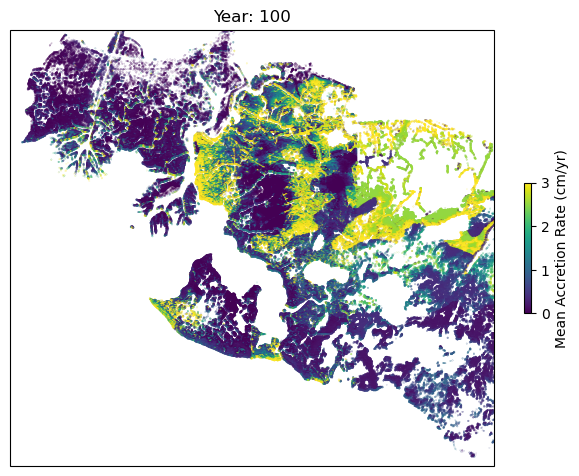

In [22]:
for year in np.arange(10,110,10):
    fig, ax= plt.subplots(1,1, subplot_kw={'projection': ccrs.epsg(EPSG)})
    sc = ax.scatter(year100['long'],year100['lat'],s=0.005,vmin=0,vmax=3, c=year100['Total Accretion %syrs (cm)' %(year)]/year)
    plt.colorbar(sc,label='Mean Accretion Rate (cm/yr)',shrink=0.3)
    plt.title('Year: ' + str(year))
    ax.set_extent([AOI.bounds.left,AOI.bounds.right,AOI.bounds.bottom,AOI.bounds.top], crs=ccrs.epsg(EPSG))
    fig.tight_layout()
    fig.savefig(example_dir/('MeanAccretion_Year%s.png'%(str(year).zfill(3))))
    plt.close()
fig, ax= plt.subplots(1,1, subplot_kw={'projection': ccrs.epsg(EPSG)})
sc = ax.scatter(year100['long'],year100['lat'],s=0.005,vmin=0,vmax=3, c=year100['Mean Accretion (cm/yr)'])
plt.colorbar(sc,label='Mean Accretion Rate (cm/yr)',shrink=0.3)
plt.title('Year: ' + str(year))
ax.set_extent([AOI.bounds.left,AOI.bounds.right,AOI.bounds.bottom,AOI.bounds.top], crs=ccrs.epsg(EPSG))
fig.tight_layout()
fig.savefig(example_dir/('MeanAccretion_100yr.png'))

In [23]:
all_figs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(example_dir)
                for f in fnmatch.filter(files,'MeanAccretion_Year*.png' )]
all_figs.sort()
with imageio.get_writer(example_dir / ('MeanAccretion_all.gif' ),mode='I',duration=500) as writer:
    for file in all_figs:
        image = imageio.imread(file)
        writer.append_data(image)



In [24]:
os.system('rm -r %s' %(tmp_dir))

0